
# **Diffusion Models**




In [1]:
from PIL import Image
import matplotlib.pyplot as plt

In [23]:
### Global Setup & Config
import math, time, random, os, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

CFG = {
    "train_subset": 10000,
    "batch_size": 128,
    "epochs": 100,
    "lr": 1e-4,
    "timesteps": 200,
    "img_size": 28,
    "save_dir": "./outputs"
}
os.makedirs(CFG["save_dir"], exist_ok=True)
print('Device:', device)
print('Config:', CFG)


Device: cuda
Config: {'train_subset': 10000, 'batch_size': 128, 'epochs': 100, 'lr': 0.0001, 'timesteps': 200, 'img_size': 28, 'save_dir': './outputs'}



## Part 1 — Setup & Baseline


In [3]:
### Task 1: MNIST Data
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
import random, os

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# --- Dataset ---
train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds       = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

idxs = list(range(len(train_ds_full)))
random.shuffle(idxs)
train_subset = Subset(train_ds_full, idxs[:CFG["train_subset"]])

train_loader = DataLoader(train_subset, batch_size=CFG["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

x0, y0 = next(iter(train_loader))
grid_path = os.path.join(CFG["save_dir"], "mnist_samples.png")
utils.save_image((x0[:16]*0.5+0.5), grid_path, nrow=8)

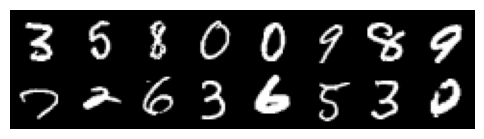

In [24]:
img = Image.open("./outputs/mnist_samples.png")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
def create_flat_tensor_from_loader(loader):
    all_data = []
    for data, _ in loader:
        all_data.append(data)
    flat_tensor = torch.cat(all_data, dim=0)
    return flat_tensor.view(len(loader.dataset), -1).to(device)

X_train = create_flat_tensor_from_loader(train_loader)
X_test = create_flat_tensor_from_loader(test_loader)


### **Diffusion Forward Process**


In [28]:

### Task 2: Forward (q)
def make_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T, device=device)

T = CFG["timesteps"]
betas = make_beta_schedule(T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ac = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_om = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_ac * x0 + sqrt_om * noise

def show_noising_example(batch=None):
    if batch is None:
        batch, _ = next(iter(train_loader))
    x0 = batch.to(device)[:8]
    steps = [0, T//4, T//2, 3*T//4, T-1]
    imgs = []
    for s in steps:
        t = torch.full((x0.size(0),), s, device=device, dtype=torch.long)
        xt = q_sample(x0, t)
        imgs.append(xt.cpu())
    grid = torch.cat(imgs, dim=0)
    path = os.path.join(CFG["save_dir"], "noising_grid.png")
    utils.save_image((grid+1)/2, path, nrow=x0.size(0))
    return path, steps

# save and print outputs
path, steps = show_noising_example()
print(f"Noising visualization saved at {path}, steps={steps}")

Noising visualization saved at ./outputs/noising_grid.png, steps=[0, 50, 100, 150, 199]


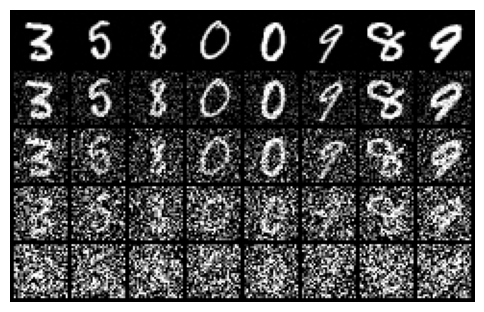

In [29]:
img = Image.open("./outputs/noising_grid.png")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()


## Part 2 — Train a Lightweight Diffusion Model

### **Small Denoising Network**


I used a more complex denoiser than the one provided in the notebook, with 1,985,809 parameters, which is still within the allowed limit. I incorporated skip connections to improve the model’s performance, because without them, even after training for many epochs, the generated samples were often distorted and resembled random shapes like chineese words rather than digits. Skip connections improve performance because they allow the network to directly pass information from earlier layers to later layers.

In [ ]:

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / half)
        args = t[:, None].float() * freqs[None]
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch, time_dim):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
#         self.gn1 = nn.GroupNorm(1, out_ch)
#         self.gn2 = nn.GroupNorm(1, out_ch)
#     def forward(self, x, t_emb):
#         h = F.silu(self.gn1(self.conv1(x)))
#         t = self.time_mlp(t_emb)[:, :, None, None]
#         h = h + t
#         h = F.silu(self.gn2(self.conv2(h)))
#         return h

# class TinyUNet(nn.Module):
#     def __init__(self, time_dim=64, base=32):
#         super().__init__()
#         self.time_mlp = nn.Sequential(SinusoidalPosEmb(time_dim), nn.Linear(time_dim, time_dim), nn.SiLU())
#         self.inc = nn.Conv2d(1, base, 3, padding=1)
#         self.down1 = Block(base, base*2, time_dim)
#         self.pool = nn.AvgPool2d(2)
#         self.mid = Block(base*2, base*2, time_dim)
#         self.up = nn.Upsample(scale_factor=2, mode='nearest')
#         self.up1 = Block(base*2, base, time_dim)
#         self.outc = nn.Conv2d(base, 1, 1)
#     def forward(self, x, t):
#         t_emb = self.time_mlp(t)
#         x1 = F.silu(self.inc(x))
#         x2 = self.pool(self.down1(x1, t_emb))
#         x3 = self.mid(x2, t_emb)
#         x4 = self.up(x3)
#         x5 = self.up1(x4, t_emb)
#         out = self.outc(x5)
#         return out


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.gn2 = nn.GroupNorm(8, out_ch)

        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_ch * 2)
        )

    def forward(self, x, t_emb):
        h = F.silu(self.gn1(self.conv1(x)))

        scale, shift = self.time_mlp(t_emb).chunk(2, dim=1)
        scale = scale[:, :, None, None]
        shift = shift[:, :, None, None]
        h = h * (1 + scale) + shift

        h = F.silu(self.gn2(self.conv2(h)))
        return h

class TinyUNet(nn.Module):
    def __init__(self, time_dim=128, base=48): # super().__init__(time_dim=64, base=32)
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU()
        )

        # Encoder
        self.inc = nn.Conv2d(1, base, 3, padding=1)
        self.down1 = Block(base, base * 2, time_dim)
        self.down2 = Block(base * 2, base * 4, time_dim)
        self.pool = nn.AvgPool2d(2)

        # Bottleneck
        self.mid = Block(base * 4, base * 4, time_dim)

        # Decoder (fixed in_channels for skip connections!)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.up1 = Block(base * 8, base * 2, time_dim)
        self.up2 = Block(base * 4, base, time_dim)

        self.outc = nn.Conv2d(base, 1, 1)


    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        # Encoder
        x1 = F.silu(self.inc(x))
        x2 = self.down1(x1, t_emb)
        x3 = self.pool(x2)
        x4 = self.down2(x3, t_emb)
        x5 = self.pool(x4)

        # Bottleneck
        x_mid = self.mid(x5, t_emb)

        # Decoder with skip connections
        x_up1 = self.up(x_mid)
        x_up1 = torch.cat([x_up1, x4], dim=1)
        x_up1 = self.up1(x_up1, t_emb)

        x_up2 = self.up(x_up1)
        x_up2 = torch.cat([x_up2, x2], dim=1)
        x_up2 = self.up2(x_up2, t_emb)

        out = self.outc(x_up2)
        return out




model = TinyUNet().to(device)
params = sum(p.numel() for p in model.parameters())
print(f"Model param count: {params:,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])

def p_losses(model, x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred_noise = model(xt, t)
    return F.mse_loss(pred_noise, noise)

def train_denoiser(model, epochs=CFG["epochs"]):
    model.train()
    for ep in range(1, epochs+1):
        t0 = time.time()
        losses = []
        for x, _ in train_loader:
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device).long()
            loss = p_losses(model, x, t)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            losses.append(loss.item())
        print(f"Epoch {ep}/{epochs} | loss={np.mean(losses):.4f} | time={time.time()-t0:.1f}s")
    return model

# train models with enough number of epochs
import time

start_time = time.time()

trained_model = train_denoiser(model, epochs=CFG["epochs"])

end_time = time.time()
total_training_time = end_time - start_time
print("Training finished. Last model saved to", os.path.join(CFG["save_dir"], f"tiny_unet_ep{CFG['epochs']}.pt"))

print(f"Total training time: {total_training_time:.2f}s")

Model param count: 1,985,809
Epoch 1/100 | loss=0.2670 | time=6.5s
Epoch 2/100 | loss=0.1127 | time=6.6s
Epoch 3/100 | loss=0.0922 | time=6.4s
Epoch 4/100 | loss=0.0832 | time=6.5s
Epoch 5/100 | loss=0.0780 | time=6.4s
Epoch 6/100 | loss=0.0742 | time=6.5s
Epoch 7/100 | loss=0.0713 | time=6.4s
Epoch 8/100 | loss=0.0688 | time=6.5s
Epoch 9/100 | loss=0.0689 | time=6.3s
Epoch 10/100 | loss=0.0651 | time=6.5s
Epoch 11/100 | loss=0.0651 | time=6.4s
Epoch 12/100 | loss=0.0636 | time=6.5s
Epoch 13/100 | loss=0.0620 | time=6.5s
Epoch 14/100 | loss=0.0607 | time=6.6s
Epoch 15/100 | loss=0.0598 | time=6.5s
Epoch 16/100 | loss=0.0620 | time=6.6s
Epoch 17/100 | loss=0.0591 | time=6.5s
Epoch 18/100 | loss=0.0595 | time=6.6s
Epoch 19/100 | loss=0.0574 | time=6.5s
Epoch 20/100 | loss=0.0570 | time=6.6s
Epoch 21/100 | loss=0.0561 | time=6.5s
Epoch 22/100 | loss=0.0560 | time=6.6s
Epoch 23/100 | loss=0.0556 | time=6.5s
Epoch 24/100 | loss=0.0559 | time=6.6s
Epoch 25/100 | loss=0.0551 | time=6.5s
Epoch

In [31]:
save_path = os.path.join(CFG["save_dir"], f"tiny_unet_ep{CFG['epochs']}.pt")
torch.save(trained_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./outputs/tiny_unet_ep100.pt



### **Generate Samples**



In [ ]:

@torch.no_grad()
def p_sample(model, xt, t):
    beta_t = betas[t][:, None, None, None]
    sqrt_one_minus_ac = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    pred_noise = model(xt, t)
    x0_hat = (xt - sqrt_one_minus_ac * pred_noise) / torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    coef1 = torch.sqrt(alphas_cumprod_prev[t])[:, None, None, None] * beta_t / (1 - alphas_cumprod[t])[:, None, None, None]
    coef2 = torch.sqrt(alphas[t])[:, None, None, None] * (1 - alphas_cumprod_prev[t])[:, None, None, None] / (1 - alphas_cumprod[t])[:, None, None, None]
    mean = coef1 * x0_hat + coef2 * xt
    if (t == 0).all():
        return mean
    noise = torch.randn_like(xt)
    var = beta_t
    return mean + torch.sqrt(var) * noise

@torch.no_grad()
def p_sample_loop(model, n=10):
    model.eval()
    xt = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    for s in reversed(range(T)):
        t = torch.full((n,), s, device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
    x_gen = xt.clamp(-1, 1)
    path = os.path.join(CFG["save_dir"], "samples_ddpm.png")
    utils.save_image((x_gen+1)/2, path, nrow=5)
    return path

# generate new samples, save and print them
sample_path = p_sample_loop(trained_model, n=10)
print(f"Generated samples saved at {sample_path}")

Generated samples saved at ./outputs/samples_ddpm.png


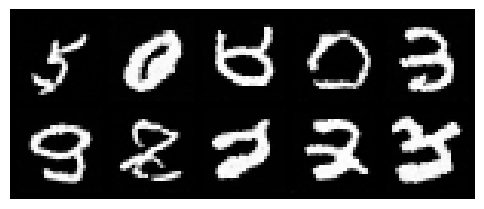

In [33]:
img = Image.open("./outputs/samples_ddpm.png")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

yes, some digits like 0, 8, 2, 9, 7, 3 are recognizable.

In [34]:
x, _ = next(iter(train_loader))
x = x.to(device)
t = torch.randint(0, T, (x.size(0),), device=device).long()
noise = torch.randn_like(x)
xt = q_sample(x, t, noise)
pred = model(xt, t)
print("Noise L2:", (noise**2).mean().item(), "Pred L2:", (pred**2).mean().item())


Noise L2: 1.00575852394104 Pred L2: 0.9625100493431091


In [41]:
@torch.no_grad()
def debug_reverse(model, n=10):
    xt = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    steps = [CFG["timesteps"]-1, CFG["timesteps"]//2, 0]
    imgs = []
    for s in reversed(range(CFG["timesteps"])):
        t = torch.full((n,), s, device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
        if s in steps:
            imgs.append(xt.cpu())
    grid = torch.cat(imgs, dim=0)
    utils.save_image((grid+1)/2, os.path.join(CFG["save_dir"], "debug_reverse.png"), nrow=n)

debug_reverse(trained_model)

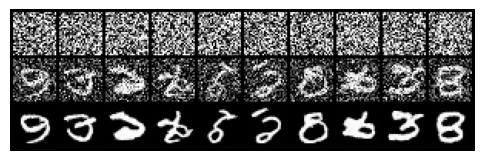

In [42]:
img = Image.open("./outputs/debug_reverse.png")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

digits 9, 3, 8 are recognizable after reverse denoising.


## Part 3 — Evaluation



In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from scipy.linalg import sqrtm
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from tqdm.auto import tqdm

In [16]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        features = F.relu(self.fc1(x))
        output = self.fc2(features)
        return output, features

In [17]:
# train LeNet on the hole dataset not just the first 1000 smaples of test set.
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

X_test_flat = test_dataset.data.view(len(test_dataset), -1).float() / 255.0
X_test_flat_binarized = (X_test_flat > 0.5).float().to(device)

X_train_flat_binarized = train_dataset.data.view(len(train_dataset), -1).float()
X_train_flat_binarized = (X_train_flat_binarized > 0.5).float()

test_loader_le= DataLoader(test_dataset, batch_size=128, shuffle=False)
train_loader_le = DataLoader(train_dataset, batch_size=128, shuffle=True)


lenet_model = LeNet().to(device)
lenet_optimizer = torch.optim.Adam(lenet_model.parameters(), lr=1e-3)
epochs = 10

lenet_model.train()
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader_le, desc=f"Epoch {epoch}/{epochs}")):
        data, target = data.to(device), target.to(device)
        lenet_optimizer.zero_grad()
        output, _ = lenet_model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        lenet_optimizer.step()

torch.save(lenet_model.state_dict(), "lenet_mnist.pth")

Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

In [18]:

lenet_model = LeNet().to(device)
lenet_model.load_state_dict(torch.load("lenet_mnist.pth"))
lenet_model.eval()

def get_features(data, batch_size=128):
    features_list = []
    if len(data.shape) == 2:
        data = data.reshape(-1, 1, 28, 28)

    dataset = TensorDataset(torch.tensor(data).to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch,) in loader:
            _, features = lenet_model(batch)
            features_list.append(features.cpu().numpy())
    return np.concatenate(features_list, axis=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)

    covmean = sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def polynomial_kernel(X, Y):
    d = X.shape[1]
    return (X @ Y.T / d + 1) ** 3

def calculate_kid(act1, act2):
    n1, n2 = act1.shape[0], act2.shape[0]
    K_11 = polynomial_kernel(act1, act1)
    K_22 = polynomial_kernel(act2, act2)
    K_12 = polynomial_kernel(act1, act2)

    mmd2 = (np.sum(K_11) - np.trace(K_11)) / (n1 * (n1 - 1)) + \
           (np.sum(K_22) - np.trace(K_22)) / (n2 * (n2 - 1)) - \
           2 * np.sum(K_12) / (n1 * n2)
    return mmd2

def get_labels_and_probs(data, batch_size=128):
    probs_list = []
    if len(data.shape) == 2:
        data = data.reshape(-1, 1, 28, 28)
    dataset = TensorDataset(torch.tensor(data).to(device))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch,) in loader:
            output, _ = lenet_model(batch)
            probs = F.softmax(output, dim=1).cpu().numpy()
            probs_list.append(probs)
    return np.concatenate(probs_list, axis=0)

def calculate_is_and_diversity(probs):
    kl_divs = probs * (np.log(probs) - np.log(np.mean(probs, axis=0, keepdims=True)))
    kl_divs = np.sum(kl_divs, axis=1)
    is_score = np.exp(np.mean(kl_divs))

    # Diversity (Entropy of marginal label distribution)
    p_y = np.mean(probs, axis=0)
    diversity = -np.sum(p_y * np.log(p_y))

    # Sparsity (KL divergence from uniform distribution)
    uniform_dist = np.full(p_y.shape, 1.0 / len(p_y))
    sparsity = np.sum(p_y * np.log(p_y / uniform_dist))

    return is_score, diversity, sparsity

def plot_samples(samples, title, n_rows=2, n_cols=10):
    samples = samples.reshape(-1, 28, 28)
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for i in range(min(len(samples), n_rows * n_cols)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()



In [19]:
real_features = get_features(X_test.cpu().numpy())

### **Lightweight Quantitative Evaluation**


In [ ]:


class TinyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (CFG["img_size"] // 4) * (CFG["img_size"] // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_tiny_classifier(epochs=5):
    clf = TinyCNN().to(device)
    opt = torch.optim.Adam(clf.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for ep in range(epochs):
        clf.train()
        losses, accs = [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            out = clf(x)
            loss = criterion(out, y)
            opt.zero_grad(); loss.backward(); opt.step()

            losses.append(loss.item())
            accs.append((out.argmax(1) == y).float().mean().item())
        print(f"[Classifier] Epoch {ep+1}/{epochs} | loss={np.mean(losses):.3f} | acc={np.mean(accs):.3f}")
    return clf

@torch.no_grad()
def generate_samples(n=1000):
    xt = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    for s in reversed(range(T)):
        t = torch.full((n,), s, device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
    return xt.clamp(-1,1)

@torch.no_grad()
def evaluate_generated_with_classifier(clf, generated_imgs):
    clf.eval()
    x_gen = (generated_imgs + 1)/2

    # classify
    preds = clf(x_gen).argmax(1).cpu().numpy()
    counts = np.bincount(preds, minlength=10)
    acc = (counts.max() / counts.sum())
    diversity_entropy = -np.sum((counts/counts.sum()+1e-8) * np.log(counts/counts.sum()+1e-8))

    print("Generated counts:", counts)
    print("Proxy accuracy (mode ratio):", acc)
    print("Diversity entropy:", diversity_entropy)
    return counts, acc, diversity_entropy


def compute_all_metrics(generated, real_features, device):

    gen_features = get_features(generated)

    fid = calculate_fid(gen_features, real_features)

    probs = get_labels_and_probs(generated)

    is_score, diversity, sparsity = calculate_is_and_diversity(probs)
    kid = calculate_kid(gen_features, real_features)

    print(f"FID: {fid:.4f}")
    print(f"Inception Score: {is_score:.4f}")
    print(f"KID: {kid:.4f}")
    return fid, is_score, kid


generated_samples = generate_samples(n=1000)
clf = train_tiny_classifier(epochs=5)
counts, acc, div_ent = evaluate_generated_with_classifier(clf, generated_samples)
fid, is_score, kid = compute_all_metrics(generated=generated_samples, real_features=real_features, device = device)

[Classifier] Epoch 1/5 | loss=0.573 | acc=0.817
[Classifier] Epoch 2/5 | loss=0.119 | acc=0.964
[Classifier] Epoch 3/5 | loss=0.065 | acc=0.981
[Classifier] Epoch 4/5 | loss=0.045 | acc=0.985
[Classifier] Epoch 5/5 | loss=0.041 | acc=0.988
Generated counts: [225  13 177 123  27 158  35  21 206  15]
Proxy accuracy (mode ratio): 0.225
Diversity entropy: 1.9322983418702688


/tmp/ipython-input-4050176068.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data).to(device))
/tmp/ipython-input-4050176068.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data).to(device))


FID: 182.6318
Inception Score: 5.6193
KID: 1428.3794


The generated counts array  [225  13 177 123  27 158  35  21 206  15] indicates that partial mode collapse has occurred, as the number of samples for each digit is highly imbalanced. In particular, digits 0, 2, 3, 5 and 8 are overrepresented as it was obvious in the previous task image that these digits were recognizable, while digits like 1 is severely underrepresented. Additionally, the proxy accuracy (mode ratio) of 0.225 is relatively low, which confirms that many modes (digits) are not well captured by the model. This suggests that, while the model can generate diverse images, it struggles to cover all digit classes evenly.

| Model | IS | FID    | KID    |
|-------|--------------------|--------|--------|
| VAE   |4.55|259.18|245164.70|
| NADE  |6.33|60.95|39554.59|
| NICE  |2.09|443.54|364312.12|
| GAN   |1.02|996.48|425708.16|
| EBM   |1.27|526.31|610860.50|
| Diffusion |5.6193|182.63|1428.37|

As we can see in the results, the Diffusion model has the least KID scores among other models.

the IS score is close to nade IS score.

the FID is less than GAN, EBM, .. but greater than NADE IS score.


### **Training & Sampling Trade-offs**



In [ ]:

@torch.no_grad()
def time_sampling(model, n=10):
    model.eval()
    t0 = time.time()
    xt = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    for s in reversed(range(T)):
        t = torch.full((n,), s, device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
    time_taken = time.time() - t0
    return time_taken

time_10_samples = time_sampling(model, n=10)
time_100_samples = time_sampling(model, n=100)
time_1_samples = time_sampling(model, n=1)

print(f"Time to generate 1 samples: {time_1_samples:.2f}s")
print(f"Time to generate 10 samples: {time_10_samples:.2f}s")
print(f"Time to generate 100 samples: {time_100_samples:.2f}s")

Time to generate 1 samples: 0.67s
Time to generate 10 samples: 0.75s
Time to generate 100 samples: 4.63s


| Model | Training Time (s)| Sampling Time single (s)|Sampling Time batch(s)
|-------|-------------|--------|----------|
| VAE   |20.4|0.0032|0.0004|
| NADE  |539.3|0.1556|0.1758|
| NICE  |50.50|0.0037|0.1267|
| GAN   |18.43|0.0004|0.0005|
| EBM   |71.49|0.0541|0.0610|
| Diffusion |653.24|0.67|4.63|

As shown in the table, the diffusion model is slower in sampling compared to other models.

DIffusion model training takes longer time than the other models.


## Part 4 — Acceleration via Distillation

### **Simple Distillation for Faster Sampling**



In [ ]:

class StudentTinyUNet(TinyUNet):
    pass

@torch.no_grad()
def teacher_generate_k_steps(model, n=10, K=10):
    model.eval()
    xt = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    step_ids = torch.linspace(T-1, 0, steps=K, dtype=torch.long, device=device)
    for s in step_ids:
        t = torch.full((n,), int(s.item()), device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
    return xt.clamp(-1,1)

def distill_student(teacher, steps_K=10, student_epochs=2, n_per_batch=64):
    student = StudentTinyUNet().to(device)
    opt = torch.optim.AdamW(student.parameters(), lr=2e-4)
    for ep in range(1, student_epochs+1):
        t0 = time.time()
        losses = []
        for _ in range(max(1, len(train_loader)//2)):
            with torch.no_grad():
                x_teacher = teacher_generate_k_steps(teacher, n=n_per_batch, K=steps_K)
                z0 = torch.randn_like(x_teacher)
            t_zero = torch.zeros(z0.size(0), dtype=torch.long, device=device)
            pred = student(z0, t_zero)
            loss = F.mse_loss(pred, x_teacher)
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
        print(f"Student epoch {ep}/{student_epochs} | loss={np.mean(losses):.4f} | time={time.time()-t0:.1f}s")
    return student

@torch.no_grad()
def student_sample(student, n=10):
    student.eval()
    z0 = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    t_zero = torch.zeros(n, dtype=torch.long, device=device)
    x = student(z0, t_zero).clamp(-1,1)
    path = os.path.join(CFG["save_dir"], "samples_student.png")
    utils.save_image((x+1)/2, path, nrow=5)
    return path

# train the student model, and compare it with your teacher model both in terms of quality and efficiency

print("\nStarting distillation...")
student_model = distill_student(model, steps_K=20, student_epochs=2)
path_student = student_sample(student_model, n=10)
print(f"Saved 10 student samples to: {path_student}")

t0_teacher = time.time()
path_teacher = teacher_generate_k_steps(model, n=10, K=20)
time_teacher_gen = time.time() - t0_teacher
path_teacher_grid = os.path.join(CFG['save_dir'], 'samples_teacher_distillation.png')
utils.save_image((path_teacher + 1)/2, path_teacher_grid, nrow=5)

t0_student = time.time()
path_student_gen = student_sample(student_model, n=10)
time_student_gen = time.time() - t0_student

print("\nComparison:\n")
print(f"Teacher (20 steps) generation time for 10 samples: {time_teacher_gen:.4f}s")
print(f"Student (1 step) generation time for 10 samples: {time_student_gen:.4f}s")
print(f"Student is {time_teacher_gen/time_student_gen:.1f}x faster.")


Starting distillation...
Student epoch 1/2 | loss=0.4548 | time=13.0s
Student epoch 2/2 | loss=0.4454 | time=12.8s
Saved 10 student samples to: ./outputs/samples_student.png

Comparison:

Teacher (20 steps) generation time for 10 samples: 0.0671s
Student (1 step) generation time for 10 samples: 0.0060s
Student is 11.2x faster.


After you replace the placeholder functions with your actual implementations, you can run the cell again to compute the metrics.